In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line

In [2]:
pose = (350, 190, 330)
map_path = "Assignment_04_Grid_Map.png"

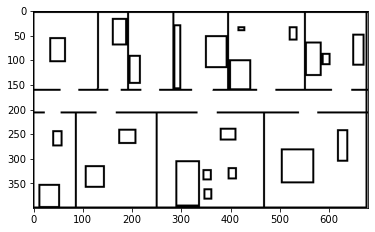

In [3]:
img = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img,'gray')
plt.show()

In [4]:
def getSensorMeasurements(mp, pose):
    rows, columns = mp.shape
    x, y, theta = pose
    
    cp = cv2.cvtColor(mp, cv2.COLOR_GRAY2RGB)
    cv2.circle(cp, (x, y), 10, (255,0,0), -1)

    thetas = np.arange(theta-125, theta+126, 2)

    rays = np.copy(cp)

    measurements = np.ones(thetas.size) * 300

    for i, ray_theta in enumerate(thetas):
        
        px = x + 300 * np.cos(np.deg2rad(ray_theta))
        py = y + 300 * np.sin(np.deg2rad(ray_theta))
        px = int(px)
        py = int(py)

        r_ray, c_ray = line(y, x, py, px)

        r_ray[r_ray<0] = 0
        r_ray[r_ray >= rows] = rows-1
        c_ray[c_ray<0] = 0
        c_ray[c_ray >= columns] = columns-1

        firstObstacle = (r_ray[-1], c_ray[-1])
        for r, c in zip(r_ray, c_ray):
            if(mp[r, c] == 0):
                measurements[i] = np.linalg.norm( np.array([x-c,y-r]))
                firstObstacle = r, c
                break
        
        new_r_ray, new_c_ray = line(y, x, firstObstacle[0], firstObstacle[1])
        rays[new_r_ray, new_c_ray] = (0,255,0)

    plt.imshow(cp)
    plt.show()

    plt.imshow(rays)
    plt.show()
    
    
    try:
        os.mkdir('Outputs')
    except:
        pass
    
    plt.imsave('Outputs/original_map_with_robot.png', cp)
    plt.imsave('Outputs/map_with_generated_rays.png', rays)
    np.savetxt('Outputs/measurements.txt', measurements)
    
    return measurements

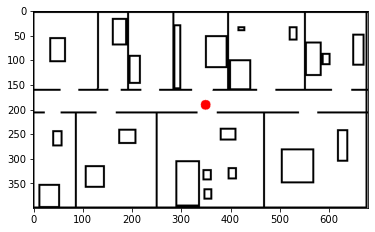

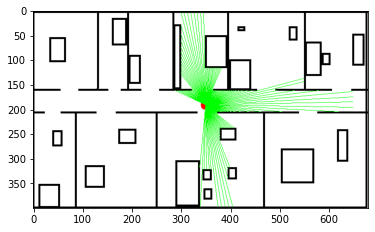

[ 68.44705983  63.0634601   59.53990259  56.08029957  52.69724851
  50.21951812  47.80167361  46.22769733  44.68780594  42.44997055
  41.01219331  41.03656906  42.52058325  79.64923101  82.80096618
  86.83893136  90.97252332  96.89685237 102.08329932 109.12836478
 117.20068259 126.3170614  138.35100289 151.48927355 168.58528999
 193.56910911 192.10674116 190.62528689 189.39112968 188.40912929
 187.77113729 187.2671888  187.04277586  75.00666637  75.10659092
  75.32595834  75.53806987  75.95393341  76.4852927   76.90253572
  77.62087348  78.44743463  79.37883849  80.41144197  81.54140053
  35.34119409  32.64965543  33.12099032  33.61547263  34.66987165
  35.22782991  36.40054945  37.01351105  38.28837944  39.62322551
  41.01219331  42.44997055  43.93176527  46.22769733  47.80167361
  50.21951812  52.69724851  56.08029957  59.53990259  63.0634601
  67.54257916  73.00684899  79.47955712  87.92041856  97.41663102
 207.16177254 205.44829033 147.87156589 182.32114524 230.82894099
 300.      

In [5]:
measurements = getSensorMeasurements(img, pose)
print(measurements)

In [8]:
def getLikelihood(mp, measurements):
    rows, columns = mp.shape

    likelihoodMap = np.zeros(mp.shape) + 0.1
    likelihoodMap[mp == 0] = 1
    likelihoodMap = cv2.GaussianBlur(likelihoodMap, (7,7), 0)
    plt.imsave('Outputs/likelihood_map.png', likelihoodMap, cmap='gray')

    likelihoodOutput = np.zeros(mp.shape)

    for x in range(columns):
        for y in range(rows):

            if(mp[y, x] == 0):
                continue

            maxValue = 0

            for theta in range(360):
                currentValue = 1
                thetas = np.arange(theta-125, theta+126, 2)

                xs = (x + measurements * np.cos(np.deg2rad(thetas))).astype(np.int32)
                ys = (y + measurements * np.sin(np.deg2rad(thetas))).astype(np.int32)

                mask = np.logical_and(np.logical_and(xs >= 0, xs < columns), np.logical_and(ys >= 0, ys < rows))

                xs = xs[mask]
                ys = ys[mask]

                outPixels = mask.size - xs.size

                currentValue = (0.1**outPixels) * np.prod(likelihoodMap[ys, xs])

                maxValue = max(maxValue, currentValue)


            likelihoodOutput[y, x] = maxValue
            
    normalized = likelihoodOutput/np.max(likelihoodOutput)
    
    kernel = np.ones((7,7), np.uint8)
    dilated = cv2.dilate(normalized, kernel)
    
    plt.imshow(dilated, 'gray')
    plt.show()
    
    robot_y, robot_x = np.unravel_index(normalized.argmax(), normalized.shape)
    
    print(f'robot likelihood position ({robot_x}, {robot_y})')
    
    try:
        os.mkdir('Outputs')
    except:
        pass
    
    plt.imsave('Outputs/likelihood_output.png', dilated, cmap='gray')

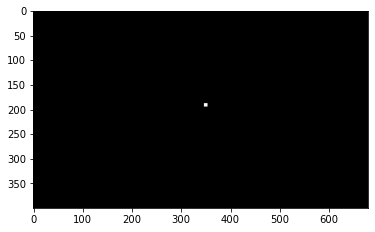

robot likelihood position (350, 190)


In [9]:
getLikelihood(img, measurements)